In [1]:
%matplotlib inline
import pandas as pd
import json
import numpy as np
from scipy import stats
from tqdm import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sn
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt

In [2]:
ols_model = LinearRegression()

In [3]:
"""
Function GRS_test(factor, resid, alpha) is to conduct GRS test according 
to Gibbons, Ross & Shanken(1989) to receive GRS-statistic and p-value.

H0: alpha1=alpha2=...=alphaN=0

Parameters:
  T = number of months
  N = number of portfolios/stocks
  L = number of factors

Inputs:
  factor: matrix of FF factors with shape (T, L)
  resid: matrix of residuals with shape (T, N)
  alpha: matrix of intercepts with shape (N, 1)

Outputs:
  f_grs: GRS-statistic
  p_grs: P-value

"""
from scipy.stats import f

def GRS_test(factor, resid, alpha):
    N = resid.shape[1]        
    T = resid.shape[0]       
    L = factor.shape[1]      

    if (T-N-L) < 0:
        print('can not conduct GRS test because T-N-L<0')
        return

    factor = np.asmatrix(factor)                   # factor matrix (T, L)
    resid = np.asmatrix(resid)                     # residual matrix (T, N)
    alpha = np.asmatrix(alpha).reshape(N, 1)       # intercept matrix (N, 1)

    mean_return_factor = (factor.mean(axis=0))

    # covariance matrix of residuals
    cov_resid = (resid.T * resid) / (T-L-1)
    # covariance matrix of factors
    cov_factor = ((factor - mean_return_factor).T * (factor - mean_return_factor)) / (T-1)

    mean_return_factor = mean_return_factor.reshape(L, 1)

    # GRS statistic
    # pinv.linalg.pinv is a pseudoinverse not a real one, for calculating the real inverse we need to use np.linalg.inv
    # However, the structure of resids matrix is oftenly a Singular matrix (one for which a inverse matrix does not exis)
    f_grs = float((T/N) * ((T-N-L)/(T-L-1)) * ((alpha.T * np.linalg.pinv(cov_resid) * alpha) / (1 + mean_return_factor.T * np.linalg.inv(cov_factor) * mean_return_factor)))

    # p-value
    p_grs = 1 - stats.f.cdf(f_grs, N, (T-N-L))

    return f_grs, p_grs


In [4]:
"""
Input Explanation:
df_beta is the dataframe of stock betas obtained by running the first stage of BJS regression  # mat(N*K)
df_f is the dataframe of factor realizations # mat(T*K)
df_lam is the dataframe of factor risk premiums obtained by running the second stage of BJS regression # mat(T*K)
df_res is the dataframe of residuals obtained by running the first stage of BJS regression # mat(T*N)
"""

def Shanken_BJS_tstats(df_betas, df_f, df_lambdas, df_res):
    beta = df_betas
    lam = df_lambdas.mean()
    f = np.mat(df_f.T)
    res = df_res
    
    beta_mul = np.dot(np.linalg.inv(np.dot(beta.T,beta)),beta.T) #mat(K*N)
    beta_rev = np.dot(beta,np.linalg.inv(np.dot(beta.T,beta))) #mat(N*K)
    cov_res = res.cov() #mat(N*N)
    beta_mul_res = np.dot(np.dot(beta_mul, cov_res),beta_rev) #mat(K*K)
    cov_f = np.mat(np.cov(f)) #mat(K*K)
    c = pd.DataFrame(1+np.dot(np.dot(lam,np.linalg.inv(cov_f)),lam.T)) #c is a coefficient 
    
    adj_cov = (1/len(df_f))*(beta_mul_res*c.values+cov_f) #mat(K*K)
    se = np.sqrt(np.diagonal(adj_cov))
    t_stats = lam.values/se
    return t_stats

In [5]:
def replacer(l,target_val=0,replace_val=np.NaN,repeat_max=10):
    #repeat_max = n (consecutive 0s over 10 times will be replaced with NAs)
    counter = 0
    new_l = []
    for e in l:
        if e == target_val: counter += 1
        else:
            counter = 0

        if counter > repeat_max:
            new_l.append(replace_val)
        else:
            new_l.append(e)

    return new_l

In [6]:
def froll_sum(x): 
    # Convert daily return to monthly return, use fix_rolling_sum function
    tmp = []
    for i in range(int(len(x)/21)): # 21 represents the trading days for one month
        res = np.sum(x[i*21:(i+1)*21])
        tmp.append(res)
    return tmp

In [7]:
## Newey-West Adjustment For a Time-Series Data, e.g. Lambdas (factor returns)
def NW_ttest(ret,h0):
  T = len(ret)
  lag = int(4*(T/100)**(2/9))
  vv = np.var(ret)

  for l in range(0,lag):
      cc=np.cov(ret[0:(len(ret)-l)].T,ret[l:len(ret)].T)[0,1]
      vv=vv+2*(1-(l+1)/lag)*cc
      t=(np.mean(ret)-h0)/np.sqrt(vv)*np.sqrt(T)
  
  return t

Import Data

In [8]:
# Import excessive market return (J203T - Rf)
df_MR = pd.read_csv('df_MR.csv')
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])
df_MR.set_index('Dates',inplace=True)

Import risk-free rate (91-day T-Bill)

In [9]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)

Import listed stock returns on the JSE

In [10]:
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])
df_SR.index = pd.to_datetime(df_SR.index)

Drop the columns of stock returns that full of 0s or NAs and replace consecutive 0s with NAs

In [11]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)].astype(np.float64)
df_SR = df_SR.dropna(axis = 0, how = 'all')
df_SR = df_SR.apply(replacer)

In [12]:
df_SR.dropna(axis=1)

,MTN.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,RMH.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,GFI.SJ.Equity,ACL.SJ.Equity,...,AFE.SJ.Equity,DSY.SJ.Equity,MRP.SJ.Equity,APN.SJ.Equity,AFX.SJ.Equity,SUR.SJ.Equity,DRD.SJ.Equity,SUI.SJ.Equity,WBO.SJ.Equity,SNT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,0.012821,-0.024693,-0.040734,-0.009132,-0.004376,-0.016666,-0.048790,-0.025318,-0.079755,-0.013234,...,0.000000,-0.004491,0.000000,0.000000,-0.013889,0.000000,-0.020201,-0.020620,-0.040822,0.000000
2000-01-06,0.075623,-0.077962,-0.047886,0.015175,-0.015470,0.024898,-0.021053,0.011332,-0.015207,0.034932,...,0.034689,-0.018187,0.000000,-0.024698,0.020762,0.000000,-0.031094,0.000000,0.000000,-0.032789
2000-01-07,0.079437,0.013423,0.034816,0.041304,0.011808,0.032262,0.004246,0.068053,0.033902,0.147389,...,0.100805,-0.086180,0.007117,0.060625,0.020340,0.021979,0.031094,0.010363,0.020619,0.003325
2000-01-10,0.066809,0.089231,0.076001,0.020973,0.100433,0.023531,0.000000,0.071096,0.016530,0.043488,...,0.000000,0.014887,0.021053,0.045994,0.036248,0.000000,0.005086,0.000000,0.010152,0.043874
2000-01-11,0.020203,0.070618,-0.050029,-0.044366,0.003312,-0.012481,-0.044182,-0.055430,-0.009151,-0.090891,...,-0.017275,-0.004934,0.000000,0.220877,-0.003241,0.021506,0.000000,0.006167,0.010050,0.017337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-12-27,-0.000119,0.004612,0.003673,0.012542,0.003590,0.004883,0.009022,-0.001472,0.025673,-0.080043,...,-0.027909,0.010917,0.007941,0.010903,0.005886,-0.030334,0.027399,0.011287,-0.010159,-0.021661


Calculate the Excess Stock Returns 

In [13]:
df_Ex_SR = df_SR-df_RF.values

Import the Factor Realizations (Mimicking portfolio returns)

In [14]:
df_FF3 = pd.read_csv('df_FF3.csv')
df_FF3.Dates = df_FF3.Dates.apply(lambda x: x[:10])
df_FF3.set_index('Dates',inplace=True)
df_FF3.index = pd.to_datetime(df_FF3.index)

In [15]:
df_FF4 = pd.read_csv('df_FF4.csv')
df_FF4.Dates = df_FF4.Dates.apply(lambda x:x[:10])
df_FF4.set_index('Dates',inplace=True)
df_FF4.index = pd.to_datetime(df_FF4.index)
df_FF4_tmp = pd.read_csv("df_FF4_tmp.csv")
df_FF4["WML"] = df_FF4_tmp["WML"].values
df_FF4

,MR_RF,SMB,HML,WML
Dates,,,,
2000-12-20,-0.0083,0.0065,0.0128,0.0068
2000-12-21,-0.0062,0.0030,-0.0000,-0.0062
2000-12-22,0.0163,-0.0085,-0.0026,-0.0005
2000-12-25,-0.0003,0.0000,0.0000,0.0000
2000-12-26,-0.0003,0.0000,0.0000,0.0000
...,...,...,...,...
2019-02-27,0.0008,0.0016,0.0017,-0.0033
2019-02-28,-0.0055,0.0014,-0.0185,-0.0077
2019-03-01,0.0034,-0.0035,0.0113,0.0007


In [16]:
df_FF5 = pd.read_csv('df_FF5.csv')
df_FF5.Dates = df_FF5.Dates.apply(lambda x:x[:10])
df_FF5.set_index('Dates',inplace=True)
df_FF5.index = pd.to_datetime(df_FF5.index)

Import Firm Characteristics 

In [17]:
df_ln_Size = pd.read_csv('df_ln_Size.csv')
df_ln_Size = df_ln_Size.replace([np.inf, -np.inf], np.nan)
df_ln_Size.Dates = df_ln_Size.Dates.apply(lambda x:x[:10])
df_ln_Size.set_index('Dates',inplace=True)
df_ln_Size.index = pd.to_datetime(df_ln_Size.index)

In [18]:
df_PE = pd.read_csv('df_std_PE.csv')
df_PE = df_PE.replace([np.inf, -np.inf], np.nan)
df_PE.Dates = df_PE.Dates.apply(lambda x:x[:10])
df_PE.set_index('Dates',inplace=True)
df_PE.index = pd.to_datetime(df_PE.index)
df_EP = 1/df_PE

In [19]:
df_PB = pd.read_csv('df_std_PB.csv')
df_PB = df_PB.replace([np.inf, -np.inf], np.nan)
df_PB.Dates = df_PB.Dates.apply(lambda x:x[:10])
df_PB.set_index('Dates',inplace=True)
df_PB.index = pd.to_datetime(df_PB.index)
df_BM = 1/df_PB

In [20]:
df_OP = pd.read_csv('df_std_OP.csv')
df_OP = df_OP.replace([np.inf, -np.inf], np.nan)
df_OP.Dates = df_OP.Dates.apply(lambda x:x[:10])
df_OP.set_index('Dates',inplace=True)
df_OP.index = pd.to_datetime(df_OP.index)

In [21]:
df_INV = pd.read_csv('df_std_INV.csv')
df_INV = df_INV.replace([np.inf, -np.inf], np.nan)
df_INV.Dates = df_INV.Dates.apply(lambda x:x[:10])
df_INV.set_index('Dates',inplace=True)
df_INV.index = pd.to_datetime(df_INV.index)

Import 18 double-sorted portfolios returns

In [22]:
df_18_PR = pd.read_csv('df_18_PR.csv')
df_18_PR.Dates = df_18_PR.Dates.apply(lambda x:x[:10])
df_18_PR.set_index('Dates',inplace=True)
df_18_PR.index = pd.to_datetime(df_18_PR.index)

Import Firm Characteristics of 18 double-sorted portfolios

In [23]:
df_18_std_Size = pd.read_csv('df_18_std_size.csv')
df_18_std_Size.Dates = df_18_std_Size.Dates.apply(lambda x:x[:10])
df_18_std_Size.set_index('Dates',inplace=True)
df_18_std_Size.index = pd.to_datetime(df_18_std_Size.index)

In [24]:
df_18_std_PE = pd.read_csv('df_18_std_PE.csv')
df_18_std_PE.Dates = df_18_std_PE.Dates.apply(lambda x:x[:10])
df_18_std_PE.set_index('Dates',inplace=True)
df_18_std_PE.index = pd.to_datetime(df_18_std_PE.index)
df_18_std_EP = 1/df_18_std_PE

In [25]:
df_18_std_OP = pd.read_csv('df_18_std_OP.csv')
df_18_std_OP.Dates = df_18_std_OP.Dates.apply(lambda x:x[:10])
df_18_std_OP.set_index('Dates',inplace=True)
df_18_std_OP.index = pd.to_datetime(df_18_std_OP.index)

In [26]:
df_18_std_INV = pd.read_csv('df_18_std_INV.csv')
df_18_std_INV.Dates = df_18_std_INV.Dates.apply(lambda x:x[:10])
df_18_std_INV.set_index('Dates',inplace=True)
df_18_std_INV.index = pd.to_datetime(df_18_std_INV.index)

In [27]:
df_18_std_Size

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,0.942657,0.357455,0.892459,1.986398,0.069024,0.374104,0.048000,0.069849,2.345359,-0.805869,-0.739840,-0.815606,-0.798091,-0.767378,-0.820553,-0.734375,-0.837613,-0.765981
2000-12-21,0.942657,0.357455,0.892459,1.986398,0.069024,0.374104,0.048000,0.069849,2.345359,-0.805869,-0.739840,-0.815606,-0.798091,-0.767378,-0.820553,-0.734375,-0.837613,-0.765981
2000-12-22,0.942657,0.357455,0.892459,1.986398,0.069024,0.374104,0.048000,0.069849,2.345359,-0.805869,-0.739840,-0.815606,-0.798091,-0.767378,-0.820553,-0.734375,-0.837613,-0.765981
2000-12-25,0.948072,0.362528,0.889354,1.990243,0.071630,0.371886,0.046339,0.068151,2.339770,-0.806071,-0.740154,-0.815790,-0.798306,-0.767645,-0.820957,-0.734698,-0.838101,-0.766250
2000-12-26,0.951308,0.365563,0.887493,1.992536,0.073189,0.370557,0.045345,0.067134,2.336418,-0.806188,-0.740340,-0.815898,-0.798432,-0.767802,-0.821196,-0.734889,-0.838391,-0.766408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.427582,1.032318,1.219934,1.249520,1.208213,0.340078,0.473927,1.322083,1.136259,-0.953475,-0.906959,-0.932339,-0.908835,-0.927355,-0.972487,-0.962794,-0.928556,-0.917113
2019-02-28,0.427652,1.032304,1.219936,1.249485,1.208191,0.340011,0.473718,1.322217,1.136320,-0.953472,-0.906947,-0.932325,-0.908820,-0.927342,-0.972489,-0.962786,-0.928548,-0.917105
2019-03-01,0.427722,1.032289,1.219937,1.249450,1.208169,0.339945,0.473512,1.322350,1.136381,-0.953470,-0.906935,-0.932311,-0.908805,-0.927329,-0.972491,-0.962778,-0.928541,-0.917096


# Winsorization

In [28]:
df_Ex_SR = df_Ex_SR.apply(lambda x: winsorize(x, (0.01, 0.01)))

In [29]:
df_FF3 = df_FF3.apply(lambda x: winsorize(x, (0.01, 0.01)))
df_FF4 = df_FF4.apply(lambda x: winsorize(x, (0.01, 0.01)))
df_FF5 = df_FF5.apply(lambda x: winsorize(x, (0.01, 0.01)))
df_MR = df_MR.apply(lambda x: winsorize(x, (0.01, 0.01)))

In [30]:
df_Ex_SR

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.020678,-0.015547,0.012542,-0.038019,-0.020355,0.003464,-0.024971,-0.046701,-0.041012,-0.009411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,-0.015876,-0.039501,0.066746,-0.000279,-0.000279,0.010867,-0.047144,-0.006779,-0.048165,0.014896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.004951,0.017172,0.066746,0.037465,-0.000275,0.021650,0.013148,0.052647,0.034541,0.041029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,0.040553,0.053297,0.066534,-0.000275,0.026405,-0.037089,0.051113,0.116362,0.050048,0.020698,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-11,0.078535,0.029097,0.019928,0.014431,0.012802,0.005955,0.051113,0.044575,-0.049104,-0.044641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,NaN,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,-0.000190,...,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190
2019-12-26,NaN,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,-0.000190,...,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190
2019-12-27,NaN,NaN,-0.000308,NaN,-0.000189,NaN,0.004422,NaN,0.003483,0.012353,...,-0.060519,0.007442,-0.003571,-0.009381,0.002857,0.018901,0.015940,-0.003086,0.023825,0.010409


In [31]:
## In Fama&French (2020), they use firm characteristics as factor loadings and then conduct TS and CS regression to 
## test the explanatory power of pure factor returns. And then they compare these two new FF5CS-Factor asset pricing models with 
## the traditional FF5TS-Factor Model(2015).

## Compare TS and CS Models

### Time-Series Factor Model I

In [32]:
## Step-1: Use double-sorted portfolio return as regressors and then run time-series regression model to obtain factor loadings and interceptions, i.e. betas and alphas, with NW Adjustment
## Step-2: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 


In [33]:
df_FF3

,MR_RF,SMB,HML
Dates,,,
2000-12-20,-0.0083,0.001800,0.01275
2000-12-21,-0.0062,0.005367,-0.00005
2000-12-22,0.0163,-0.008000,-0.00260
2000-12-25,-0.0003,0.000000,0.00000
2000-12-26,-0.0003,0.000000,0.00000
...,...,...,...
2019-02-27,0.0008,-0.000800,0.00170
2019-02-28,-0.0055,-0.000567,-0.01675
2019-03-01,0.0034,-0.002067,0.01135


In [34]:
df_FF3.apply(lambda x: stats.ttest_1samp(x,0))

,MR_RF,SMB,HML
0,1.922305,-2.914462,3.004228
1,0.054627,0.003580,0.002676


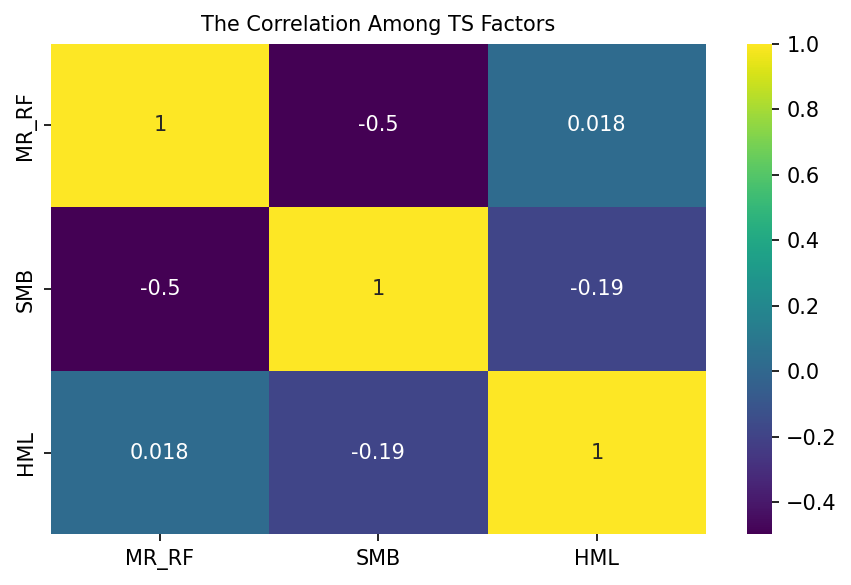

In [35]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_FF3.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among TS Factors', fontsize=10)
plt.show()

In [36]:
df_FF5

,MR_RF,SMB,HML,RMW,CMA
Dates,,,,,
2000-12-20,-0.0083,0.0065,0.0128,0.0040,-0.0019
2000-12-21,-0.0062,0.0030,-0.0000,-0.0009,0.0136
2000-12-22,0.0163,-0.0085,-0.0026,-0.0046,-0.0066
2000-12-25,-0.0003,0.0000,0.0000,0.0000,0.0000
2000-12-26,-0.0003,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...
2019-02-27,0.0008,0.0016,0.0017,-0.0080,-0.0027
2019-02-28,-0.0055,0.0014,-0.0168,0.0037,-0.0094
2019-03-01,0.0034,-0.0035,0.0113,-0.0043,-0.0053


In [37]:
df_FF5.apply(lambda x: stats.ttest_1samp(x,0))

,MR_RF,SMB,HML,RMW,CMA
0,1.922305,-2.105158,2.991786,2.429447,-0.714885
1,0.054627,0.035330,0.002788,0.015159,0.474715


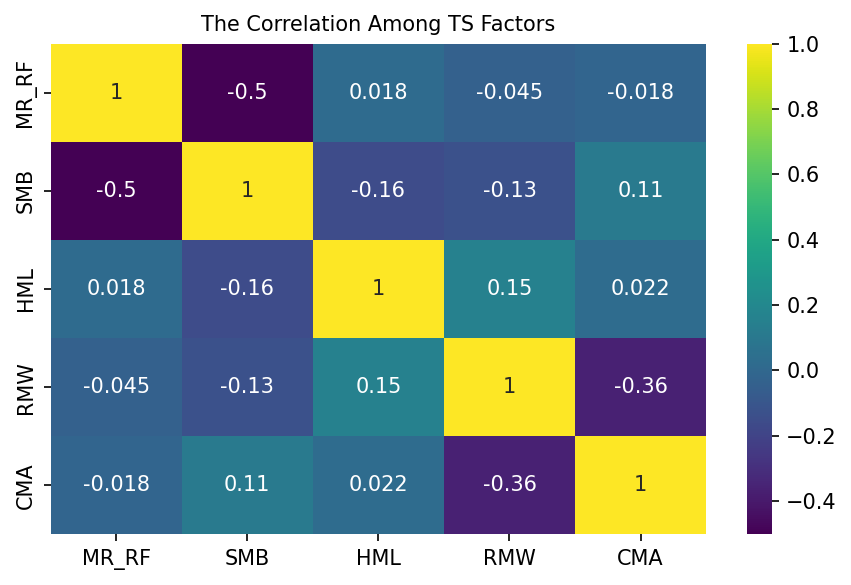

In [38]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_FF5.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among TS Factors', fontsize=10)
plt.show() 

In [39]:
df_Ex_SR.loc[df_FF3.index,:].dropna(axis=1)

,MTN.SJ.Equity,AEG.SJ.Equity,NTC.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,RMH.SJ.Equity,SAP.SJ.Equity,IMP.SJ.Equity,NPK.SJ.Equity,GFI.SJ.Equity,...,ART.SJ.Equity,TRE.SJ.Equity,JSC.SJ.Equity,FBR.SJ.Equity,AEL.SJ.Equity,SNT.SJ.Equity,CLH.SJ.Equity,HDC.SJ.Equity,BEL.SJ.Equity,CSB.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.026354,-0.007816,0.030507,-0.003822,0.001842,0.021295,0.029178,-0.011064,-0.004971,0.020912,...,-0.000265,-0.000265,-0.000265,0.044187,-0.001805,0.009523,-0.000265,0.006852,0.042907,-0.000265
2000-12-21,-0.018043,-0.000265,-0.020674,-0.010899,-0.015112,-0.013478,-0.019796,-0.005996,-0.009744,0.057104,...,-0.000265,-0.000265,0.023265,0.042294,-0.014230,-0.006780,-0.013976,-0.000265,-0.036111,-0.010215
2000-12-22,0.066746,0.001274,-0.000267,0.017430,-0.000267,0.054838,0.034619,0.033634,0.037120,-0.025771,...,-0.000267,-0.000267,0.088680,-0.042827,-0.000267,0.002996,0.014793,-0.000267,0.028512,-0.000267
2000-12-25,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,...,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267
2000-12-26,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,...,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267,-0.000267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-0.001017,-0.000189,-0.017675,-0.003005,0.018852,-0.010127,-0.011901,0.039687,-0.007300,0.004176,...,-0.002296,-0.010965,-0.114599,0.058635,0.021089,-0.015901,-0.002110,-0.031199,-0.000189,0.003896
2019-02-28,-0.011025,0.288689,-0.002937,-0.006718,0.008198,-0.001225,-0.010516,0.076016,0.020995,0.001726,...,-0.061077,0.012366,-0.095499,0.009862,-0.010771,0.019292,0.006031,-0.008094,-0.000189,-0.008141
2019-03-01,-0.055826,-0.224052,0.004126,0.007208,-0.004898,-0.001374,0.026444,-0.049211,0.026526,-0.017906,...,0.047961,0.038963,-0.000188,-0.000633,0.010394,-0.011734,-0.002496,0.007717,-0.000188,-0.015814


In [40]:
# FF5-Factor Time Series Regression with Newey-West Adjustment
df_Ex_SR_trnct = df_Ex_SR.loc[df_FF5.index,:].dropna(axis=1)

all_betas = []
all_cons_ts = []
all_std_errs = []
all_Rs = []
all_sd_res = []

betas = []
labels = []
cons_ts = []
std_errs = []
Rs = []
sd_res = []

for j in tqdm(df_Ex_SR.columns):

    df_index = (df_Ex_SR.loc[:, j].dropna().index).intersection(df_FF5.index)

    if len(df_index) > 10:
        lag = int(4*((len(df_Ex_SR.loc[df_index, j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR.loc[df_index, j].astype(np.float64), sm.add_constant(
            df_FF5.loc[df_index, :].astype(np.float64)))
        res = ols.fit(cov_type='HAC', cov_kwds={'maxlags': lag})

        b = list(res.params)
        t = res.tvalues[0]
        se = res.bse[0]
        r = res.rsquared
        sr = res.resid.std()
        betas.append(b)
        cons_ts.append(t)
        std_errs.append(se)
        Rs.append(r)
        sd_res.append(sr)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_cons_ts.append(pd.DataFrame(cons_ts))
all_std_errs.append(pd.DataFrame(std_errs))
all_Rs.append(pd.DataFrame(Rs))
all_sd_res.append(pd.DataFrame(sd_res))

100%|██████████| 245/245 [00:01<00:00, 184.63it/s]


In [41]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AFT.SJ.Equity   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     9.763
Date:                Mon, 20 Jun 2022   Prob (F-statistic):           2.85e-09
Time:                        16:44:45   Log-Likelihood:                 7462.5
No. Observations:                3215   AIC:                        -1.491e+04
Df Residuals:                    3209   BIC:                        -1.488e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.000      1.866      0.062   -3.66e-05       0.001
MR_RF          0.3200      0.051      6.278      0.000       0.220       0.420
SMB            0.3897      0.087      4.498      0.000       0.220       0.560
HML            0.1204      0.078      1.544      0.123      -0.032       0.273
RMW            0.1952      0.076      2.553      0.011       0.045       0.345
CMA           -0.1525      0.083     -1.836      0.066      -0.315       0.010
==============================================================================
Omnibus:                     2991.121   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           552140.736
Skew:                           3.852   Prob(JB):                         0.00
Kurtosis:                      66.737   Cond. No.                         202.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

In [42]:
TS_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
TS_betas.columns = ['Intercepts','MKT','SMB','HML','RMW','CMA','Stocks']
TS_betas = TS_betas.set_index('Stocks')
TS_betas

,Intercepts,MKT,SMB,HML,RMW,CMA
Stocks,,,,,,
FDS.SJ.Equity,0.007157,0.497575,-0.697465,-0.513860,0.291973,-0.226889
MOZ.SJ.Equity,0.001590,0.410354,-0.836975,-0.137655,-0.438302,0.055407
MTN.SJ.Equity,-0.000245,0.851625,-0.518688,0.002255,0.128786,-0.007458
TRT.SJ.Equity,0.000638,0.301552,0.419525,0.049822,0.265672,-0.378455
AEG.SJ.Equity,0.000116,0.579894,-0.310462,0.099850,-0.287030,-0.086878
...,...,...,...,...,...,...
MTH.SJ.Equity,0.001682,0.951276,0.073453,-0.199301,-0.009125,-0.083265
DIA.SJ.Equity,0.001247,0.077355,-0.001260,0.077416,-0.192893,-0.174182
CTK.SJ.Equity,0.001090,0.256165,0.430739,-0.013228,0.253523,-0.081836


In [43]:
## The alphas are missing pricing errors of asset pricing model (FF5-Factor), which are also the intercepts of time series regression
TS_alphas = TS_betas.iloc[:,0]
TS_alphas.describe()

count    243.000000
mean       0.000732
std        0.001031
min       -0.001504
25%        0.000098
50%        0.000505
75%        0.001064
max        0.007157
Name: Intercepts, dtype: float64

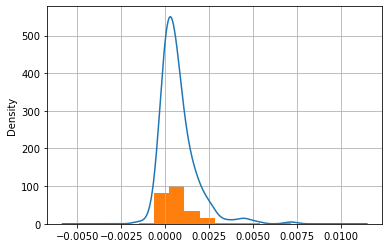

In [44]:
TS_alphas.plot(kind='density')
TS_alphas.hist()
plt.show()

In [45]:
all_cons_ts[0]

,0
0,1.596312
1,2.171961
2,-0.993807
3,1.419911
4,0.136500
...,...
238,0.787236
239,2.331231
240,2.096727
241,2.187041


In [46]:
all_ses = pd.DataFrame(all_std_errs[0])
all_ses.index = TS_alphas.index
all_ses.columns = ['std_errs']
all_ses

,std_errs
Stocks,
FDS.SJ.Equity,0.004483
MOZ.SJ.Equity,0.000732
MTN.SJ.Equity,0.000246
TRT.SJ.Equity,0.000450
AEG.SJ.Equity,0.000852
...,...
MTH.SJ.Equity,0.002136
DIA.SJ.Equity,0.000535
CTK.SJ.Equity,0.000520


In [47]:
TS_alphas_t = pd.concat([all_cons_ts[0], pd.DataFrame(labels)], axis = 1)
TS_alphas_t.columns = ['t-statistics','Stocks']
TS_alphas_t = TS_alphas_t.set_index('Stocks')
TS_alphas_t

,t-statistics
Stocks,
FDS.SJ.Equity,1.596312
MOZ.SJ.Equity,2.171961
MTN.SJ.Equity,-0.993807
TRT.SJ.Equity,1.419911
AEG.SJ.Equity,0.136500
...,...
MTH.SJ.Equity,0.787236
DIA.SJ.Equity,2.331231
CTK.SJ.Equity,2.096727


#### Results_1

In [48]:
### Step2: Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(TS_alphas))*21*100,np.nanmean(abs(TS_alphas_t)))
### The mis-pricing errros is about 0.04% daily return, which is strongly significant

1.7310145365651306 1.4767159838576784


In [49]:
### Step3: Calculate the cross-sectional variance of LHS average returns and then divided by the mean of squared alphas
cs_var = np.var(df_SR.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(TS_alphas))/cs_var)


1.9782328478327051


In [50]:
### Step4: Substract the squared standard error of each intercept to adjust for the noise in the Step-3
A_lamda = np.mean(pd.DataFrame(np.square(TS_alphas).values)-pd.DataFrame(np.square(all_ses).values))
print(A_lamda/cs_var)

0    1.392274
dtype: float64


/Users/runxinlin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [51]:
### Step5: the average of the regression R^2; the average of the standard errors of the intercepts; 
### the average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.mean(all_Rs)), 'As(a): ' + str(np.mean(all_ses.values)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(all_sd_res)*np.sqrt(21)))

AR^2: 0.0707354403604103 As(a): 0.002377387039269736 As(e): 0.12021556273901214


In [52]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(TS_alphas)/np.var(df_Ex_SR.mean()))

-0.29946182595947346

### Cross-section Factor Model I

In [53]:
## Step-1: Use 18 (3*6) doubt-sorted portfolios as test assets and run CS regression to obtain R_zt and four pure factor returns;
## Step-2: (Mis-Pricing error at each time t)-> alpha,it = R,it - (Rz,t+beta,i*lambda,t), t=1,2,3,...,T, Vi
## Step-3: Use t.test to Calculate the time-series mean of alpha,it and obtain their corresponding t-statistics
## Step-4: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 


In [54]:
## Import 18 double-sorted portfolios returns

In [55]:
ols_model = LinearRegression()

In [56]:
df_18_PR = pd.read_csv('df_18_PR.csv')
df_18_PR.Dates = df_18_PR.Dates.apply(lambda x:x[:10])
df_18_PR.set_index('Dates',inplace=True)

In [57]:
df_18_PR

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,0.0062,-0.0079,-0.0238,-0.0114,-0.0021,-0.0140,-0.0069,-0.0123,-0.0179,-0.0047,-0.0152,-0.0002,0.0033,-0.0070,-0.0022,-0.0171,0.0022,-0.0024
2000-12-21,-0.0069,-0.0137,0.0024,-0.0046,-0.0139,-0.0037,-0.0023,-0.0043,-0.0035,-0.0008,0.0087,-0.0100,-0.0021,-0.0010,-0.0011,0.0183,-0.0127,-0.0077
2000-12-22,0.0112,0.0131,0.0152,0.0138,0.0108,0.0159,0.0038,0.0176,0.0195,0.0058,0.0027,0.0070,0.0029,0.0097,0.0099,0.0004,0.0108,-0.0022
2000-12-25,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2000-12-26,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.0084,-0.0003,0.0063,0.0023,0.0040,0.0097,0.0082,0.0021,0.0017,0.0098,-0.0063,0.0085,0.0014,0.0079,0.0100,0.0055,0.0006,0.0174
2019-02-28,-0.0125,-0.0073,0.0017,-0.0193,-0.0027,0.0023,-0.0019,-0.0030,-0.0082,-0.0157,-0.0111,0.0070,0.0060,-0.0083,-0.0230,-0.0230,-0.0034,0.0022
2019-03-01,0.0065,0.0013,-0.0041,-0.0022,0.0029,-0.0007,-0.0001,0.0014,-0.0029,-0.0033,0.0162,-0.0154,-0.0051,-0.0051,0.0020,-0.0085,-0.0009,0.0049


In [58]:
## Import Firm Characteristics of 18 double-sorted portfolios

In [59]:
df_18_std_Size = pd.read_csv('df_18_std_size.csv')
df_18_std_Size.Dates = df_18_std_Size.Dates.apply(lambda x:x[:10])
df_18_std_Size.set_index('Dates',inplace=True)
df_18_std_Size

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,0.942657,0.357455,0.892459,1.986398,0.069024,0.374104,0.048000,0.069849,2.345359,-0.805869,-0.739840,-0.815606,-0.798091,-0.767378,-0.820553,-0.734375,-0.837613,-0.765981
2000-12-21,0.942657,0.357455,0.892459,1.986398,0.069024,0.374104,0.048000,0.069849,2.345359,-0.805869,-0.739840,-0.815606,-0.798091,-0.767378,-0.820553,-0.734375,-0.837613,-0.765981
2000-12-22,0.942657,0.357455,0.892459,1.986398,0.069024,0.374104,0.048000,0.069849,2.345359,-0.805869,-0.739840,-0.815606,-0.798091,-0.767378,-0.820553,-0.734375,-0.837613,-0.765981
2000-12-25,0.948072,0.362528,0.889354,1.990243,0.071630,0.371886,0.046339,0.068151,2.339770,-0.806071,-0.740154,-0.815790,-0.798306,-0.767645,-0.820957,-0.734698,-0.838101,-0.766250
2000-12-26,0.951308,0.365563,0.887493,1.992536,0.073189,0.370557,0.045345,0.067134,2.336418,-0.806188,-0.740340,-0.815898,-0.798432,-0.767802,-0.821196,-0.734889,-0.838391,-0.766408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.427582,1.032318,1.219934,1.249520,1.208213,0.340078,0.473927,1.322083,1.136259,-0.953475,-0.906959,-0.932339,-0.908835,-0.927355,-0.972487,-0.962794,-0.928556,-0.917113
2019-02-28,0.427652,1.032304,1.219936,1.249485,1.208191,0.340011,0.473718,1.322217,1.136320,-0.953472,-0.906947,-0.932325,-0.908820,-0.927342,-0.972489,-0.962786,-0.928548,-0.917105
2019-03-01,0.427722,1.032289,1.219937,1.249450,1.208169,0.339945,0.473512,1.322350,1.136381,-0.953470,-0.906935,-0.932311,-0.908805,-0.927329,-0.972491,-0.962778,-0.928541,-0.917096


In [60]:
df_18_std_PE = pd.read_csv('df_18_std_PE.csv')
df_18_std_PE.Dates = df_18_std_PE.Dates.apply(lambda x:x[:10])
df_18_std_PE.set_index('Dates',inplace=True)
df_18_std_PE

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,-0.900659,-0.411347,0.551820,-0.122545,-0.400719,-0.190703,-0.432970,-0.016427,0.069313,-0.782024,-0.352475,2.203033,-0.418637,-0.689674,2.894326,-0.397909,-0.721700,0.119299
2000-12-21,-0.895906,-0.416109,0.546832,-0.126412,-0.405572,-0.186008,-0.432607,-0.018843,0.063027,-0.777771,-0.344896,2.191835,-0.420100,-0.687900,2.908686,-0.381971,-0.723272,0.106988
2000-12-22,-0.892946,-0.420407,0.546203,-0.129412,-0.406900,-0.184194,-0.434744,-0.017081,0.067775,-0.774850,-0.344973,2.186750,-0.421400,-0.687031,2.914790,-0.379626,-0.719047,0.097090
2000-12-25,-0.891487,-0.422514,0.545891,-0.130884,-0.407549,-0.183302,-0.435790,-0.016215,0.070105,-0.773411,-0.345008,2.184242,-0.422036,-0.686601,2.917770,-0.378472,-0.716969,0.092230
2000-12-26,-0.890619,-0.423765,0.545705,-0.131759,-0.407934,-0.182772,-0.436411,-0.015701,0.071490,-0.772554,-0.345029,2.182747,-0.422413,-0.686344,2.919536,-0.377786,-0.715732,0.089342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-1.087697,-0.739813,2.201939,-0.572948,0.312987,1.732538,0.938174,-0.473959,0.888074,-1.057970,-0.824239,1.117544,-0.831072,-0.665375,0.276073,0.049502,-0.487887,-0.775871
2019-02-28,-1.089170,-0.740504,2.200315,-0.573356,0.310967,1.731917,0.936775,-0.474267,0.885956,-1.056867,-0.825013,1.120994,-0.831928,-0.666265,0.281049,0.052721,-0.487457,-0.775867
2019-03-01,-1.090631,-0.741182,2.198695,-0.573756,0.308963,1.731299,0.935382,-0.474563,0.883848,-1.055763,-0.825769,1.124400,-0.832776,-0.667165,0.285998,0.055933,-0.487060,-0.775852


In [61]:
df_18_std_OP = pd.read_csv('df_18_std_OP.csv')
df_18_std_OP.Dates = df_18_std_OP.Dates.apply(lambda x:x[:10])
df_18_std_OP.set_index('Dates',inplace=True)
df_18_std_OP

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,-0.305114,0.108086,-0.008410,1.009224,-0.371517,-1.003130,-0.204715,-0.431790,0.575749,0.222890,1.100296,0.595127,1.810449,-0.254222,-2.255018,-1.781615,0.247647,0.946063
2000-12-21,-0.305114,0.108086,-0.008410,1.009224,-0.371517,-1.003130,-0.204715,-0.431790,0.575749,0.222890,1.100296,0.595127,1.810449,-0.254222,-2.255018,-1.781615,0.247647,0.946063
2000-12-22,-0.305114,0.108086,-0.008410,1.009224,-0.371517,-1.003130,-0.204715,-0.431790,0.575749,0.222890,1.100296,0.595127,1.810449,-0.254222,-2.255018,-1.781615,0.247647,0.946063
2000-12-25,-0.309103,0.109622,-0.012920,1.013839,-0.376368,-1.010133,-0.209717,-0.437361,0.572703,0.218960,1.098564,0.592129,1.810496,-0.259348,-2.238501,-1.790568,0.283763,0.943944
2000-12-26,-0.311488,0.110541,-0.015636,1.016564,-0.379269,-1.014296,-0.212719,-0.440693,0.570836,0.216580,1.097460,0.590291,1.810425,-0.262422,-2.228430,-1.795864,0.305503,0.942616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,0.047384,0.169347,0.115514,0.973985,-0.092869,-0.424752,-0.035035,0.132169,0.216665,-1.170871,1.192086,0.007795,1.687556,0.090273,-2.398853,-1.788791,0.231200,1.047197
2019-02-28,0.050689,0.169590,0.116233,0.974381,-0.092427,-0.422251,-0.032406,0.132580,0.216818,-1.172467,1.191647,0.006432,1.686716,0.089356,-2.400595,-1.788657,0.230136,1.044228
2019-03-01,0.053965,0.169830,0.116945,0.974771,-0.091989,-0.419770,-0.029799,0.132988,0.216970,-1.174046,1.191208,0.005080,1.685878,0.088446,-2.402317,-1.788520,0.229081,1.041281


In [62]:
df_18_std_INV = pd.read_csv('df_18_std_INV.csv')
df_18_std_INV.Dates = df_18_std_INV.Dates.apply(lambda x:x[:10])
df_18_std_INV.set_index('Dates',inplace=True)
df_18_std_INV

,B_Value,B_Neutral_PE,B_Growth,B_Robust,B_Neutral_OP,B_Weak,B_Conservative,B_Neutral_INV,B_Aggressive,S_Value,S_Neutral_PE,S_Growth,S_Robust,S_Neutral_OP,S_Weak,S_Conservative,S_Neutral_INV,S_Aggressive
Dates,,,,,,,,,,,,,,,,,,
2000-12-20,-0.320455,-0.725071,0.328962,0.283652,-0.461130,-0.336654,-1.241484,-0.429337,1.740570,-0.590169,-0.322096,2.295917,0.271474,0.841033,-0.964468,-1.223396,-0.524202,1.376856
2000-12-21,-0.320455,-0.725071,0.328962,0.283652,-0.461130,-0.336654,-1.241484,-0.429337,1.740570,-0.590169,-0.322096,2.295917,0.271474,0.841033,-0.964468,-1.223396,-0.524202,1.376856
2000-12-22,-0.320455,-0.725071,0.328962,0.283652,-0.461130,-0.336654,-1.241484,-0.429337,1.740570,-0.590169,-0.322096,2.295917,0.271474,0.841033,-0.964468,-1.223396,-0.524202,1.376856
2000-12-25,-0.320533,-0.725170,0.328917,0.283605,-0.461215,-0.336733,-1.241609,-0.429420,1.740597,-0.590261,-0.322174,2.295972,0.271426,0.841015,-0.963928,-1.223520,-0.523835,1.376865
2000-12-26,-0.320580,-0.725229,0.328890,0.283577,-0.461266,-0.336780,-1.241684,-0.429470,1.740613,-0.590316,-0.322221,2.296005,0.271398,0.841003,-0.963604,-1.223594,-0.523615,1.376870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,-0.825316,0.038799,0.043991,0.350256,-0.155431,1.521690,-0.786766,-0.234443,2.077403,-0.522005,0.758385,-0.536770,0.488227,-0.304769,-1.148009,-1.938079,-0.317630,1.490467
2019-02-28,-0.827368,0.040026,0.044361,0.350750,-0.154578,1.521070,-0.787155,-0.233373,2.077826,-0.522573,0.757679,-0.535676,0.488224,-0.305047,-1.148364,-1.937715,-0.317974,1.489889
2019-03-01,-0.829404,0.041245,0.044729,0.351240,-0.153731,1.520453,-0.787542,-0.232311,2.078244,-0.523137,0.756978,-0.534591,0.488221,-0.305323,-1.148714,-1.937353,-0.318316,1.489313


In [63]:
len(df_18_std_Size)==len(df_18_std_PE)==len(df_18_std_OP)==len(df_18_std_INV)==len(df_18_PR)

True

In [64]:
## Step-1: Use 18 (3*6) doubt-sorted portfolios as test assets and run CS regression to obtain R_zt
## and four pure factor returns at each time t;

In [65]:
all_lambdas = []
all_intercepts = []

lambdas = []
intercepts = []
Dates = []
index_times = list(df_18_PR.T.columns)

for k in tqdm(df_18_PR.T.columns):
    # k is time t in 4750 days

    df_index = ((((df_18_std_Size.T.loc[:, k].replace(-np.inf, np.nan).dropna().index).
                 intersection(df_18_std_PE.T.loc[:, k].replace(-np.inf, np.nan).dropna().index)).
                 intersection(df_18_PR.T.loc[:, index_times[index_times.index(k)]].dropna().index)).
                intersection(df_18_std_OP.T.loc[:, k].dropna().index)).\
        intersection(df_18_std_INV.T.loc[:, k].dropna().index)

    if len(df_index) > 10:

        l = list(ols_model.fit((pd.concat([df_18_std_Size.T.loc[df_index, k],
                                           df_18_std_PE.T.loc[df_index, k],
                                           df_18_std_OP.T.loc[df_index, k],
                                           df_18_std_INV.T.loc[df_index, k]], axis=1).values),
                               (df_18_PR.T.loc[df_index, index_times[index_times.index(k)]].values)).coef_)

        h = ols_model.fit((pd.concat([df_18_std_Size.T.loc[df_index, k],
                                      df_18_std_PE.T.loc[df_index, k],
                                      df_18_std_OP.T.loc[df_index, k],
                                      df_18_std_INV.T.loc[df_index, k]], axis=1).values),
                          (df_18_PR.T.loc[df_index, index_times[index_times.index(k)]].values)).intercept_

        lambdas.append(l)
        intercepts.append(h)
        Dates.append(k)

all_lambdas.append(pd.DataFrame(lambdas))
all_intercepts.append(pd.DataFrame(intercepts))

100%|██████████| 4750/4750 [00:23<00:00, 199.94it/s]


In [66]:
## Through performing FM-2 at each time t, we got the pure factor return time-series for MC/PE/OP/INV and intercept (Rzt)
df_CS_FF4 = pd.concat([all_lambdas[0], pd.DataFrame(Dates)], axis = 1)
df_CS_FF4.columns = ['Size','PE','OP','INV','Dates']
df_CS_FF4 = df_CS_FF4.set_index(['Dates'])
df_CS_FF4

,Size,PE,OP,INV
Dates,,,,
2000-12-20,-0.003496,0.000332,0.001952,-0.000357
2000-12-21,-0.000954,-0.000732,-0.001852,-0.000648
2000-12-22,0.004393,0.000246,-0.001754,0.000570
2000-12-25,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2019-02-27,-0.001402,0.000836,-0.002045,0.001005
2019-02-28,-0.002140,0.005767,0.007298,-0.000513
2019-03-01,0.001442,-0.003470,-0.000897,0.002338


In [67]:
df_Rzt = pd.concat([all_intercepts[0], pd.DataFrame(Dates)], axis = 1)
df_Rzt.columns = ['Rzt','Dates']
df_Rzt = df_Rzt.set_index(['Dates'])
df_Rzt

,Rzt
Dates,
2000-12-20,-0.007411
2000-12-21,-0.003272
2000-12-22,0.009328
2000-12-25,0.000000
2000-12-26,0.000000
...,...
2019-02-27,0.005400
2019-02-28,-0.006678
2019-03-01,-0.000728


In [68]:
df_18_PR.T.mean()

Dates
2000-12-20   -0.007411
2000-12-21   -0.003272
2000-12-22    0.009328
2000-12-25    0.000000
2000-12-26    0.000000
                ...   
2019-02-27    0.005400
2019-02-28   -0.006678
2019-03-01   -0.000728
2019-03-04   -0.005822
2019-03-05   -0.006606
Length: 4750, dtype: float64

In [69]:
df_18_CS = pd.concat([df_Rzt, df_CS_FF4], axis = 1)
df_18_CS

,Rzt,Size,PE,OP,INV
Dates,,,,,
2000-12-20,-0.007411,-0.003496,0.000332,0.001952,-0.000357
2000-12-21,-0.003272,-0.000954,-0.000732,-0.001852,-0.000648
2000-12-22,0.009328,0.004393,0.000246,-0.001754,0.000570
2000-12-25,0.000000,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2019-02-27,0.005400,-0.001402,0.000836,-0.002045,0.001005
2019-02-28,-0.006678,-0.002140,0.005767,0.007298,-0.000513
2019-03-01,-0.000728,0.001442,-0.003470,-0.000897,0.002338


In [70]:
m_df_18_CS = df_18_CS
m_df_18_CS['month'] = np.array(df_18_CS.index.astype(str).str[:7])
m_df_18_CS = m_df_18_CS.groupby('month').sum()
df_18_CS = df_18_CS.drop(['month'], axis = 1)
# m_df_18_CS = m_df_18_CS.iloc[:-1,:]
m_df_18_CS

,Rzt,Size,PE,OP,INV
month,,,,,
2000-12,0.017300,-0.000109,0.005284,-0.001102,-0.002467
2001-01,0.054800,0.007398,-0.001684,0.010093,-0.020373
2001-02,-0.024672,-0.014028,-0.001771,-0.006750,-0.007083
2001-03,-0.066872,-0.026997,-0.024022,0.005506,0.003115
2001-04,0.051144,0.018261,0.009289,-0.014639,-0.003776
...,...,...,...,...,...
2018-11,-0.024828,0.003408,-0.002583,0.004042,-0.006286
2018-12,-0.002978,0.001941,0.004501,-0.000882,-0.008516
2019-01,-0.004572,0.021708,-0.000672,-0.008871,0.005912


In [71]:
m_df_18_CS.mean()*100

Rzt     0.174798
Size    0.114967
PE     -0.154457
OP      0.154877
INV     0.048239
dtype: float64

In [72]:
m_df_18_CS.std()

Rzt     0.037296
Size    0.014578
PE      0.010008
OP      0.011347
INV     0.008696
dtype: float64

In [73]:
m_df_18_CS.apply(lambda x: stats.ttest_1samp(x,0))

,Rzt,Size,PE,OP,INV
0,0.695170,1.169743,-2.289247,2.024422,0.822751
1,0.487686,0.243376,0.023018,0.044141,0.411545


In [74]:
df_18_CS.apply(lambda x: stats.ttest_1samp(x,0))

,Rzt,Size,PE,OP,INV
0,0.960442,1.036108,-2.299161,1.735116,0.696593
1,0.336881,0.300205,0.021539,0.082785,0.486091


In [75]:
## Step-2: (Mis-Pricing error at each time t)-> alpha,it = R,it - (Rz,t + firm characteristics,i*lambda,t), t=1,2,3,...,T, Vi

In [76]:
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

In [77]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)]
df_SR = df_SR.apply(replacer)

In [78]:
df_SR = df_SR.loc[df_Rzt.index,:]
df_SR.shape[1]

245

In [79]:
df_std_OP = pd.read_csv('df_std_OP.csv')

df_std_INV = pd.read_csv('df_std_INV.csv')

df_std_OP.Dates = df_std_OP.Dates.apply(lambda x:x[:10])

df_std_OP.set_index('Dates',inplace=True)

df_std_INV.Dates = df_std_INV.Dates.apply(lambda x:x[:10])

df_std_INV.set_index('Dates',inplace=True)

In [80]:
df_ln_Size = pd.read_csv('df_ln_Size.csv')

df_std_PE = pd.read_csv('df_std_PE.csv')

df_ln_Size.Dates = df_ln_Size.Dates.apply(lambda x:x[:10])

df_ln_Size.set_index('Dates',inplace=True)

df_std_PE.Dates = df_std_PE.Dates.apply(lambda x:x[:10])

df_std_PE.set_index('Dates',inplace=True)

In [81]:
df_ln_Size = df_ln_Size.loc[df_SR.index,:]

In [82]:
df_std_PE = df_std_PE.loc[df_SR.index,:]

In [83]:
df_std_OP = df_std_OP.loc[df_SR.index,:]

In [84]:
df_std_INV = df_std_INV.loc[df_SR.index,:]

In [85]:
len(df_ln_Size)==len(df_std_PE)==len(df_SR)==len(df_std_OP)==len(df_std_INV)

True

In [86]:
# ## (average beta) * lambda + Rz
# Prediction = df_ln_Size.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,0])+\
# df_std_PE.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,1])+\
# df_std_OP.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,2])+\
# df_std_INV.apply(lambda x: np.mean(x) * df_CS_FF4.iloc[:,3])

In [87]:
# beta * lambda + Rz
Prediction = df_ln_Size.apply(lambda x: x * df_CS_FF4.iloc[:,0])+\
df_std_PE.apply(lambda x: x * df_CS_FF4.iloc[:,1])+\
df_std_OP.apply(lambda x: x * df_CS_FF4.iloc[:,2])+\
df_std_INV.apply(lambda x: x * df_CS_FF4.iloc[:,3])

In [88]:
intc_index = df_SR.index.intersection(Prediction.index)
intc_columns = df_SR.columns.intersection(Prediction.columns)

In [89]:
Prediction.loc[intc_index,intc_columns]

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,NaN,-0.003530,-0.010683,0.005502,NaN,NaN,0.000069,-0.001313,-0.002432,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,NaN,0.000526,-0.005016,-0.001295,NaN,NaN,0.000284,-0.001390,0.000100,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,NaN,0.003870,0.014254,-0.006301,NaN,NaN,-0.000340,0.001795,0.002763,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-25,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,-0.001547,-0.003061,-0.000520,0.000929,-0.001937,-0.001933,0.001192,-0.002525,-0.003388,...,-0.000954,-0.000285,NaN,NaN,NaN,NaN,-0.000068,-0.001484,-0.000272,-0.000647
2019-02-28,NaN,0.000665,-0.003168,0.004459,-0.002414,0.000195,0.002661,0.002055,-0.002471,-0.005375,...,-0.000690,-0.001675,NaN,NaN,NaN,NaN,-0.001293,0.003321,-0.001848,0.001187
2019-03-01,NaN,-0.001748,0.002556,0.001674,-0.000614,0.001609,-0.000504,-0.000535,0.002530,0.003924,...,-0.000505,0.001756,NaN,NaN,NaN,NaN,0.000905,0.000468,0.001159,0.000250


In [90]:
df_SR.loc[intc_index,intc_columns]

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,-0.011211,-0.117783,-0.026088,0.0,-0.007551,0.000000,0.030772,-0.057759,-0.003556,0.002107,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,-0.049637,-0.068993,-0.017778,0.0,0.000000,-0.013129,-0.020409,-0.055570,-0.010633,-0.014847,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,0.044758,0.017700,0.073467,0.0,0.001541,0.000000,0.000000,0.055570,0.017697,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-25,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,NaN,-0.000829,NaN,0.000000,NaN,-0.017486,NaN,-0.002816,0.019041,...,0.045120,0.003494,-0.057679,NaN,0.014148,0.052096,0.000000,0.006645,0.006842,0.043952
2019-02-28,NaN,NaN,-0.010837,NaN,0.288878,NaN,-0.002748,NaN,-0.006529,0.008386,...,-0.019803,0.000498,0.006231,-0.009097,0.015452,0.007431,0.009941,0.000000,0.000000,-0.006689
2019-03-01,NaN,NaN,-0.055638,NaN,-0.288878,NaN,0.004315,NaN,0.007396,-0.004710,...,0.000000,-0.000498,-0.006231,-0.064075,0.036975,-0.006652,0.006275,0.001985,0.014291,-0.018629


In [91]:
## After obtaining the return prediction of each stock i at each time t, we now can calculate the mis-pricing errors of 
## CS factor models by using real stock time subtract its corresponding prediction return


In [92]:
df_alphas = df_SR.loc[intc_index,intc_columns].apply(lambda x: x - df_Rzt.iloc[:,0]) - Prediction.loc[intc_index,intc_columns]
df_alphas

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-12-20,NaN,-0.106842,-0.007994,0.001909,NaN,NaN,0.038113,-0.049035,0.006287,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-21,NaN,-0.066246,-0.009490,0.004567,NaN,NaN,-0.017421,-0.050908,-0.007462,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-22,NaN,0.004502,0.049886,-0.003026,NaN,NaN,-0.008987,0.044447,0.005606,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-25,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-26,NaN,0.000000,0.000000,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-27,NaN,NaN,-0.003168,NaN,-0.006329,NaN,-0.020953,NaN,-0.005691,0.017029,...,0.040675,-0.001621,NaN,NaN,NaN,NaN,-0.005332,0.002729,0.001713,0.039199
2019-02-28,NaN,NaN,-0.000990,NaN,0.297969,NaN,0.001269,NaN,0.002620,0.020439,...,-0.012435,0.008850,NaN,NaN,NaN,NaN,0.017912,0.003357,0.008526,-0.001198
2019-03-01,NaN,NaN,-0.057466,NaN,-0.287536,NaN,0.005546,NaN,0.005594,-0.007906,...,0.001233,-0.001526,NaN,NaN,NaN,NaN,0.006098,0.002244,0.013860,-0.018151


In [93]:
## The Newey-West Adjustment is used to avoid the time-series autocorrelation of alphas

In [94]:
## Step-3: Use t.test to Calculate the time-series mean of alpha,it and obtain their corresponding t-statistics

In [95]:
TSmean_alphas = df_alphas.apply(lambda x: np.mean(x))
TSmean_alphas.describe()

count    224.000000
mean       0.000038
std        0.001056
min       -0.009288
25%       -0.000066
50%        0.000241
75%        0.000468
max        0.001496
dtype: float64

In [96]:
tstats_alphas = df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else stats.ttest_1samp(x,0.0,nan_policy='omit')[0])
tstats_alphas = pd.DataFrame(tstats_alphas)
tstats_alphas.T

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
0,NaN,0.34359,0.181712,0.60263,-1.86688,2.721472,2.333276,-0.395809,1.728562,0.787348,...,-1.57735,1.854258,NaN,NaN,NaN,NaN,0.404044,1.192134,1.961063,1.58079


In [97]:
# calculate the percentage of NAs in 
np.sum(df_alphas.apply(lambda x: np.isnan(x).sum()==len(x), axis = 0))/df_alphas.shape[1]

0.08571428571428572

In [98]:
## Step-4: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 

#### Results_2

In [99]:
### Step2: Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(TSmean_alphas))*21*100,np.nanmean(abs(tstats_alphas)))

1.1927177129334685 0.9299935367804942


In [100]:
### Step3: Calculate the squared alphas and then divided by the cross-sectional variance of LHS average returns  
cs_var = np.var(df_SR.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(TSmean_alphas))/cs_var)

0.21341748851725936


In [101]:
### Step4: Substract the squared standard error of each intercept to adjust for the noise in the Step-3
alphas_se = df_alphas.apply(lambda x: np.std(x)/np.sqrt(len(x)))
A_lamda = np.mean(pd.DataFrame(np.square(TSmean_alphas).values)-pd.DataFrame(np.square(alphas_se).values))
print(A_lamda/cs_var)

0    0.159022
dtype: float64


/Users/runxinlin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [102]:
## calculate the time-series regression R-squared for model i (i <- 0~[N-1])
# SST1 = np.square(df_Ex_SR.iloc[:,1] - df_Ex_SR.iloc[:,1].mean()).sum()
# SS_res1 = np.square(df_alphas.iloc[:,1]).mean()
# R_sqr1 = 1 - (SS_res1/SST1)
# R_sqr1 

In [103]:
## loop the above procedure
SST = np.square(df_SR.apply(lambda x: x-np.mean(x))).sum()
SS_res = np.square(df_alphas).mean()
R_sqr = 1 - SS_res/SST

In [104]:
#### calculate the time-series R^2 for CS factor model I
SST_1 = np.square(df_SR.apply(lambda x: x-np.mean(x))).sum()
R_sqrt = 1-((np.square(df_alphas).mean())/SST_1)

In [105]:
R_sqrt.describe()

count    224.000000
mean       0.999538
std        0.000535
min        0.995646
25%        0.999489
50%        0.999768
75%        0.999816
max        0.999992
dtype: float64

In [106]:
alpha_ses = df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else np.std(x)/np.sqrt(len(x)))
alpha_sds =  df_alphas.apply(lambda x: np.NaN if np.all(x!=x) else np.std(x))

In [107]:
### Step5: the average of the regression R^2; the average of the standard errors of the intercepts; 
### the average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.nanmean(R_sqr.values)), 'As(a): ' + str(np.mean(alpha_ses)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(alpha_sds)*np.sqrt(21)))

AR^2: 0.9995378233636956 As(a): 0.0019033282969513725 As(e): 0.131177850182053


In [108]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(df_alphas.mean())/np.var(df_Ex_SR.mean()))

-0.36164883732661934

### Cross-section Factor Model II

In [109]:
## Step-1: Use firm characteristics as factor loadings in FM-2 regression and get the pure factor returns 
## Step-2: Use pure factor return from step-1 and run time-series regression get cross-sectional betas and alphas(mis-pricing errors), with NW Adjustment
## Step-3: Alpha Test: Calcualte the mean of abs(alphas,i) and abs(t.statistic_alphas,i) 

In [110]:
ols_model = LinearRegression()

In [111]:
df_RF = pd.read_csv('df_RF.csv',index_col=0)
df_SR = pd.read_csv('df_SR.csv',index_col=0)
df_SR.index = df_SR.index.to_series().apply(lambda x:x[:10])

In [112]:
df_SR = df_SR.loc[:, (df_SR != 0).any(axis=0)]
df_SR = df_SR.apply(replacer)
df_SR.shape[1]

245

In [113]:
df_Ex_SR = df_SR-df_RF.values
df_Ex_SR

,FDS.SJ.Equity,MOZ.SJ.Equity,MTN.SJ.Equity,TRT.SJ.Equity,AEG.SJ.Equity,ECO.SJ.Equity,NTC.SJ.Equity,SFT.SJ.Equity,WHL.SJ.Equity,SOL.SJ.Equity,...,REB.SJ.Equity,EQU.SJ.Equity,CLI.SJ.Equity,MCG.SJ.Equity,DGH.SJ.Equity,MTH.SJ.Equity,DIA.SJ.Equity,CTK.SJ.Equity,SSS.SJ.Equity,AFT.SJ.Equity
Dates,,,,,,,,,,,,,,,,,,,,,
2000-01-05,-0.020678,-0.015547,0.012542,-0.038019,-0.020355,0.003464,-0.024971,-0.046701,-0.041012,-0.009411,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,-0.015876,-0.039501,0.075345,-0.000279,-0.000279,0.010867,-0.078240,-0.006779,-0.048165,0.014896,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,0.004951,0.017172,0.079162,0.037465,-0.000275,0.021650,0.013148,0.052647,0.034541,0.041029,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-10,0.040553,0.053297,0.066534,-0.000275,0.026405,-0.037089,0.088956,0.116362,0.075726,0.020698,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-11,0.078535,0.029097,0.019928,0.014431,0.012802,0.005955,0.070342,0.044575,-0.050305,-0.044641,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-25,NaN,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,-0.000190,...,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190
2019-12-26,NaN,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,NaN,-0.000190,-0.000190,...,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190,-0.000190
2019-12-27,NaN,NaN,-0.000308,NaN,-0.000189,NaN,0.004422,NaN,0.003483,0.012353,...,-0.062710,0.007442,-0.003571,-0.009381,0.002857,0.018901,0.015940,-0.003086,0.023825,0.010409


In [114]:
df_MR = pd.read_csv('df_MR.csv')

In [115]:
df_MR.Dates = df_MR.Dates.apply(lambda x:x[:10])

In [116]:
df_MR.set_index('Dates',inplace=True)
df_MR.columns = ['MKT']

In [117]:
## Through FM cross-sectional regression, we got the pure factor return of MC/PE/OP/INV
df_CS_FF4

,Size,PE,OP,INV
Dates,,,,
2000-12-20,-0.003496,0.000332,0.001952,-0.000357
2000-12-21,-0.000954,-0.000732,-0.001852,-0.000648
2000-12-22,0.004393,0.000246,-0.001754,0.000570
2000-12-25,0.000000,0.000000,0.000000,0.000000
2000-12-26,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...
2019-02-27,-0.001402,0.000836,-0.002045,0.001005
2019-02-28,-0.002140,0.005767,0.007298,-0.000513
2019-03-01,0.001442,-0.003470,-0.000897,0.002338


In [118]:
## Test FF5CS-Factor Asset Pricing Models by using TS Regression

In [119]:
df_MR

,MKT
Dates,
2000-01-05,-0.0108
2000-01-06,0.0012
2000-01-07,0.0248
2000-01-10,0.0323
2000-01-11,0.0024
...,...
2019-12-25,-0.0002
2019-12-26,-0.0002
2019-12-27,0.0031


In [120]:
df_CS_FF5 = pd.concat([df_MR.loc[df_CS_FF4.index,:], df_CS_FF4], axis = 1)
df_CS_FF5 = df_CS_FF5.rename(columns={'Size':'MC'})
df_CS_FF5

,MKT,MC,PE,OP,INV
Dates,,,,,
2000-12-20,-0.0083,-0.003496,0.000332,0.001952,-0.000357
2000-12-21,-0.0062,-0.000954,-0.000732,-0.001852,-0.000648
2000-12-22,0.0163,0.004393,0.000246,-0.001754,0.000570
2000-12-25,-0.0003,0.000000,0.000000,0.000000,0.000000
2000-12-26,-0.0003,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
2019-02-27,0.0008,-0.001402,0.000836,-0.002045,0.001005
2019-02-28,-0.0055,-0.002140,0.005767,0.007298,-0.000513
2019-03-01,0.0034,0.001442,-0.003470,-0.000897,0.002338


In [121]:
m_df_CS_FF5 = df_CS_FF5
m_df_CS_FF5['month'] = np.array(df_CS_FF5.index.astype(str).str[:7])
m_df_CS_FF5 = m_df_CS_FF5.groupby('month').sum()
df_CS_FF5 = df_CS_FF5.drop(['month'], axis = 1)
m_df_CS_FF5

,MKT,MC,PE,OP,INV
month,,,,,
2000-12,0.0107,-0.000109,0.005284,-0.001102,-0.002467
2001-01,0.0851,0.007398,-0.001684,0.010093,-0.020373
2001-02,-0.0068,-0.014028,-0.001771,-0.006750,-0.007083
2001-03,-0.0935,-0.026997,-0.024022,0.005506,0.003115
2001-04,0.0921,0.018261,0.009289,-0.014639,-0.003776
...,...,...,...,...,...
2018-11,-0.0365,0.003408,-0.002583,0.004042,-0.006286
2018-12,0.0375,0.001941,0.004501,-0.000882,-0.008516
2019-01,0.0234,0.021708,-0.000672,-0.008871,0.005912


In [122]:
m_df_CS_FF5.mean()*100

MKT    0.691045
MC     0.114967
PE    -0.154457
OP     0.154877
INV    0.048239
dtype: float64

In [123]:
m_df_CS_FF5.std()

MKT    0.046434
MC     0.014578
PE     0.010008
OP     0.011347
INV    0.008696
dtype: float64

In [124]:
m_df_CS_FF5.apply(lambda x: stats.ttest_1samp(x,0))

,MKT,MC,PE,OP,INV
0,2.207386,1.169743,-2.289247,2.024422,0.822751
1,0.028325,0.243376,0.023018,0.044141,0.411545


In [125]:
df_CS_FF5.apply(lambda x: stats.ttest_1samp(x, 0), axis=0)

,MKT,MC,PE,OP,INV
0,1.898812,1.036108,-2.299161,1.735116,0.696593
1,0.057650,0.300205,0.021539,0.082785,0.486091


In [126]:
df_CS_FF5.corr()

,MKT,MC,PE,OP,INV
MKT,1.000000,0.494478,0.081469,-0.111215,-0.005922
MC,0.494478,1.000000,0.099486,-0.252728,0.285595
PE,0.081469,0.099486,1.000000,0.124224,0.052068
OP,-0.111215,-0.252728,0.124224,1.000000,-0.181766
INV,-0.005922,0.285595,0.052068,-0.181766,1.000000


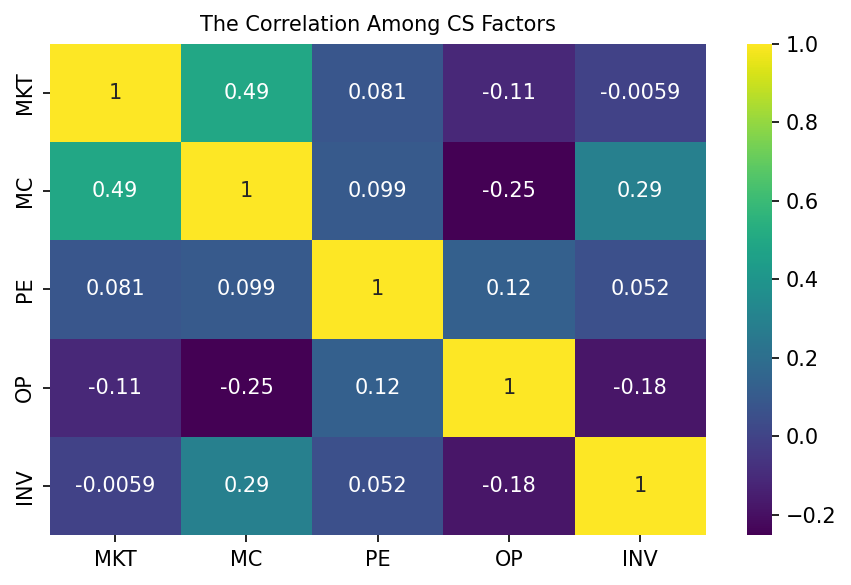

In [127]:
plt.figure(figsize=(6, 4), dpi=150, tight_layout=True)
corrMatrix = df_CS_FF5.corr()
sn.heatmap(corrMatrix, annot=True, cmap="viridis")
plt.title('The Correlation Among CS Factors', fontsize=10)
plt.show()

In [128]:
# FF5CS-Factor Time Series Regression with Newey-West Adjustment
all_betas = []
all_std_errs = []
all_Rs_CS = []
all_sd_res_CS = []

betas = []
labels = []
std_errs = []
Rs = []
sd_res = []

for j in tqdm(df_Ex_SR.columns):

    df_index = (df_Ex_SR.loc[:, j].dropna(
    ).index).intersection(df_CS_FF5.index)

    if len(df_index) > 10:
        lag = int(4*((len(df_Ex_SR.loc[df_index, j]))/100)**(1/9))
        ols = sm.OLS(df_Ex_SR.loc[df_index, j].astype(np.float64), sm.add_constant(
            df_CS_FF5.loc[df_index, :].astype(np.float64)))
        res = ols.fit()
        res = ols.fit(cov_type='HAC', cov_kwds={'maxlags': lag})
        b = list(res.params)
        se = list(res.bse)
        r = res.rsquared
        sr = res.resid.std()
        betas.append(b)
        std_errs.append(se)
        Rs.append(r)
        sd_res.append(sr)
        labels.append(j)

all_betas.append(pd.DataFrame(betas))
all_std_errs.append(pd.DataFrame(std_errs))
all_Rs_CS.append(pd.DataFrame(Rs))
all_sd_res_CS.append(pd.DataFrame(sd_res))

100%|██████████| 245/245 [00:01<00:00, 157.66it/s]


In [129]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          AFT.SJ.Equity   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     9.039
Date:                Mon, 20 Jun 2022   Prob (F-statistic):           1.52e-08
Time:                        16:45:14   Log-Likelihood:                 7261.3
No. Observations:                3215   AIC:                        -1.451e+04
Df Residuals:                    3209   BIC:                        -1.447e+04
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      0.753      0.451      -0.000       0.001
MKT            0.3236      0.054      5.977      0.000       0.218       0.430
MC            -0.6176      0.200     -3.085      0.002      -1.010      -0.225
PE            -0.7213      0.258     -2.798      0.005      -1.227      -0.216
OP             0.3856      0.221      1.745      0.081      -0.047       0.819
INV            0.2366      0.297      0.798      0.425      -0.345       0.818
==============================================================================
Omnibus:                     2347.896   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           390899.713
Skew:                           2.546   Prob(JB):                         0.00
Kurtosis:                      56.779   Cond. No.                         578.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 5 lags and without small sample correction
"""

In [130]:
df_betas = pd.concat([all_betas[0], pd.DataFrame(labels)], axis = 1)
df_betas.columns = ['Intercepts','MKT','Size','PE','OP','INV','Stocks']
df_betas = df_betas.set_index('Stocks')
df_betas

,Intercepts,MKT,Size,PE,OP,INV
Stocks,,,,,,
FDS.SJ.Equity,0.000206,0.204127,3.399913,1.366161,2.597444,3.224395
MOZ.SJ.Equity,0.000719,0.396435,1.124277,0.828141,-0.484250,-1.543846
MTN.SJ.Equity,-0.000310,0.828477,1.178897,-0.401949,0.328430,-0.819010
TRT.SJ.Equity,0.000293,0.275267,-0.460297,-0.573262,0.721198,1.102806
AEG.SJ.Equity,-0.001349,0.625480,0.145674,0.072358,-0.469957,-0.339184
...,...,...,...,...,...,...
MTH.SJ.Equity,-0.001125,1.150754,-0.484420,-0.554346,-0.167428,-0.260827
DIA.SJ.Equity,0.000024,0.314466,-0.565570,-0.428909,-0.642253,1.096690
CTK.SJ.Equity,0.000276,0.371486,-1.066032,-0.919431,1.028851,0.532966


In [131]:
## The alphas are missing pricing errors of asset pricing model (FF5-Factor), which are also the intercepts of time series regression
alphas = df_betas.iloc[:,0]
alphas.describe()

count    243.000000
mean      -0.000095
std        0.001093
min       -0.011356
25%       -0.000273
50%        0.000078
75%        0.000303
max        0.002878
Name: Intercepts, dtype: float64

In [132]:
df_SE = pd.concat([all_std_errs[0], pd.DataFrame(labels)], axis = 1)
df_SE.columns = ['Intercepts','MKT','Size','PE','OP','INV','Stocks']
df_SE = df_SE.set_index('Stocks')
df_SE

,Intercepts,MKT,Size,PE,OP,INV
Stocks,,,,,,
FDS.SJ.Equity,0.005156,0.390501,1.410816,2.211350,2.731644,2.331600
MOZ.SJ.Equity,0.000830,0.138587,0.410822,0.440498,0.412069,0.452100
MTN.SJ.Equity,0.000268,0.038119,0.132268,0.158591,0.102748,0.143425
TRT.SJ.Equity,0.000476,0.055916,0.207599,0.286453,0.244964,0.272327
AEG.SJ.Equity,0.000478,0.068562,0.321564,0.333177,0.362250,0.316920
...,...,...,...,...,...,...
MTH.SJ.Equity,0.002545,0.371680,0.754177,1.554883,0.650012,0.880798
DIA.SJ.Equity,0.000465,0.268509,0.501826,0.442676,0.316725,0.689037
CTK.SJ.Equity,0.000522,0.102051,0.296194,0.375318,0.341845,0.459695


In [133]:
alphas_se = df_SE.iloc[:,0]
alphas_se.describe()

count    243.000000
mean       0.000595
std        0.000595
min        0.000154
25%        0.000269
50%        0.000397
75%        0.000692
max        0.005156
Name: Intercepts, dtype: float64

In [134]:
## Alpha Test (Fama & French, 2020)
### Step 1: Calculate t-statistics of alphas by using the formula: t-stats,i = alphas,i/s.e.(alphas,i)
alphas_t = alphas/alphas_se
alphas_t = alphas_t.replace(-np.inf,np.nan)
alphas_t.describe()

count    243.000000
mean       0.086416
std        1.073896
min       -3.088026
25%       -0.606775
50%        0.197538
75%        0.817345
max        2.940866
Name: Intercepts, dtype: float64

In [135]:
pd.DataFrame(alphas_t)

,Intercepts
Stocks,
FDS.SJ.Equity,0.040000
MOZ.SJ.Equity,0.866252
MTN.SJ.Equity,-1.156108
TRT.SJ.Equity,0.615744
AEG.SJ.Equity,-2.821259
...,...
MTH.SJ.Equity,-0.442174
DIA.SJ.Equity,0.051776
CTK.SJ.Equity,0.528908


#### Results_3

In [136]:
### Step2: Calculate the absolute value of alphas and alphas_t, then calculate their mean respectively
print(np.mean(abs(alphas))*21*100,np.nanmean(abs(alphas_t)))
### The mis-pricing errros is about 0.8% daily return, which is strongly significant

1.1255936384243976 0.8622143435767801


In [137]:
### Step3: Calculate the cross-sectional variance of LHS average returns and then divided by the mean of squared alphas
cs_var = np.var(df_SR.apply(lambda x: np.mean(x), axis = 0))
print(np.mean(np.square(alphas))/cs_var)

1.4878559452345137


In [138]:
### Step4: Substract the squared standard error of each intercept to adjust for the noise in the Step-3
A_lamda = np.mean(pd.DataFrame(np.square(alphas).values)-pd.DataFrame(np.square(alphas_se).values))
print(A_lamda/cs_var)

0    0.61104
dtype: float64


/Users/runxinlin/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [139]:
### Step5: the average of the regression R^2; the average of the standard errors of the intercepts; 
### the average of the standard deviations of the regression residuals.
print('AR^2: ' + str(np.mean(all_Rs_CS)), 'As(a): ' + str(np.nanmean(alphas_se.values)*np.sqrt(21)), \
      'As(e): ' + str(np.mean(all_sd_res_CS)*np.sqrt(21)))

AR^2: 0.07195355626249389 As(a): 0.0027275106613179672 As(e): 0.1415437360109672


In [140]:
## Calculate Cross-sectional R-squared, how much the total variance of expected stock returns can be explained by the model?
1-(np.var(alphas)/np.var(df_Ex_SR.mean()))

-0.4580099005265219

## The Correlation Between Betas and Characteristcs

In [141]:
TS_betas.iloc[:,1:]

,MKT,SMB,HML,RMW,CMA
Stocks,,,,,
FDS.SJ.Equity,0.497575,-0.697465,-0.513860,0.291973,-0.226889
MOZ.SJ.Equity,0.410354,-0.836975,-0.137655,-0.438302,0.055407
MTN.SJ.Equity,0.851625,-0.518688,0.002255,0.128786,-0.007458
TRT.SJ.Equity,0.301552,0.419525,0.049822,0.265672,-0.378455
AEG.SJ.Equity,0.579894,-0.310462,0.099850,-0.287030,-0.086878
...,...,...,...,...,...
MTH.SJ.Equity,0.951276,0.073453,-0.199301,-0.009125,-0.083265
DIA.SJ.Equity,0.077355,-0.001260,0.077416,-0.192893,-0.174182
CTK.SJ.Equity,0.256165,0.430739,-0.013228,0.253523,-0.081836
